#Trần Hoàn Đức Duy - 19521434

#Bước 1: chuẩn bị ảnh

In [5]:
classes = ['cat','dog','tree','car']

In [2]:
!mkdir images
%cd images

mkdir: cannot create directory ‘images’: File exists
/content/drive/MyDrive/Programming/Python for machine learning/data/images


In [4]:
%%capture
!pip install icrawler

In [25]:
from icrawler.builtin import GoogleImageCrawler

for keyword in classes:
  google_crawler = GoogleImageCrawler(storage={'root_dir': keyword})
  google_crawler.crawl(keyword=keyword, max_num=5)

Xóa ảnh sai định dạng

In [8]:
from pathlib import Path
import imghdr
import os

data_dir = "./"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow, deleted")
            os.remove(filepath)

In [3]:
%cd ..

/content/drive/MyDrive/Programming/Python for machine learning/data


#Bước 2: Load tất cả ảnh

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224,224)

datagen = ImageDataGenerator()
classes = ['cat','dog','tree','car']
ds = datagen.flow_from_directory('images',
                                 target_size = image_size,
                                 classes = classes,
                                 class_mode = 'sparse',
                                 shuffle = False)

Found 16 images belonging to 4 classes.


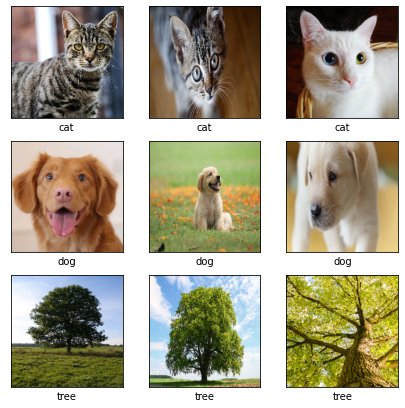

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
for i in range(9):
  img = ds[0][0][i]
  label = classes[int(ds[0][1][i])]
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img.astype('uint8'))
  plt.xlabel(label)
plt.show()

#Bước 3: Rút trích đặc trưng từ pretrained model VGG16

In [72]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [73]:
model = VGG16(weights='imagenet',
              input_shape = (224,224,3),
              include_top = True)

model = tf.keras.Model(model.input,model.layers[-2].output)

input = tf.keras.Input(shape = (224,224,3))
x = preprocess_input(input)
output = model(x)

model = tf.keras.Model(input,output)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 model_7 (Functional)        (None, 4096)              134260544 
                                                                 
Total params: 134,260,544
Trainable params: 134,260,544
Non-trainable params: 0
_________________________________________________________________


In [99]:
X= model.predict(ds)
X.shape

(16, 4096)

#Bước 4: Đọc ảnh chi vấn

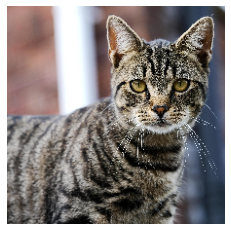

In [100]:
image_query = ds[0][0][0:1]
plt.imshow(image_query[0].astype('uint8'))
plt.axis('off')
plt.show()

#Bước 5: Rút trích đặc trưng ảnh truy vấn

In [101]:
query = model.predict(image_query)
query.shape

(1, 4096)

#Bước 6: Lấy đặc trưng ảnh truy vấn để tìm top k=3 đặc trưng gần nhất

In [102]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=3)

neigh.fit(X)

NearestNeighbors(n_neighbors=3)

In [103]:
top_k = neigh.kneighbors(query,return_distance=False)
top_k

array([[0, 2, 7]])

#Bước 7: Show top k ảnh tương ứng với áo đặc trưng ở bước 6

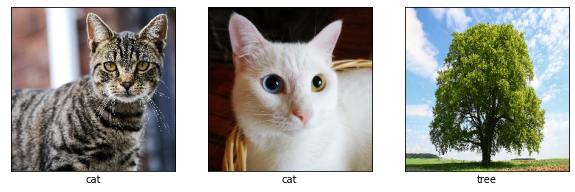

In [104]:
plt.figure(figsize=(10,10))
for idx,i in enumerate(top_k.squeeze()):
  img = ds[0][0][i]
  label = classes[int(ds[0][1][i])]
  plt.subplot(1,3,idx+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img.astype('uint8'))
  plt.xlabel(label)
plt.show()